Outlier Detection

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./datasets/processed_data.csv')

In [3]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,4,1408,0,3,0,4,1,1,2.17,1,5953
1,4,1387,0,0,0,1,1,1,2.33,1,5953
2,0,1213,0,0,0,0,1,1,2.17,1,5956
3,5,1559,0,1,0,2,1,1,2.25,1,5955
4,5,1549,0,1,0,1,1,1,2.33,1,5955


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  int64  
 1   flight            300153 non-null  int64  
 2   source_city       300153 non-null  int64  
 3   departure_time    300153 non-null  int64  
 4   stops             300153 non-null  int64  
 5   arrival_time      300153 non-null  int64  
 6   destination_city  300153 non-null  int64  
 7   class             300153 non-null  int64  
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 25.2 MB


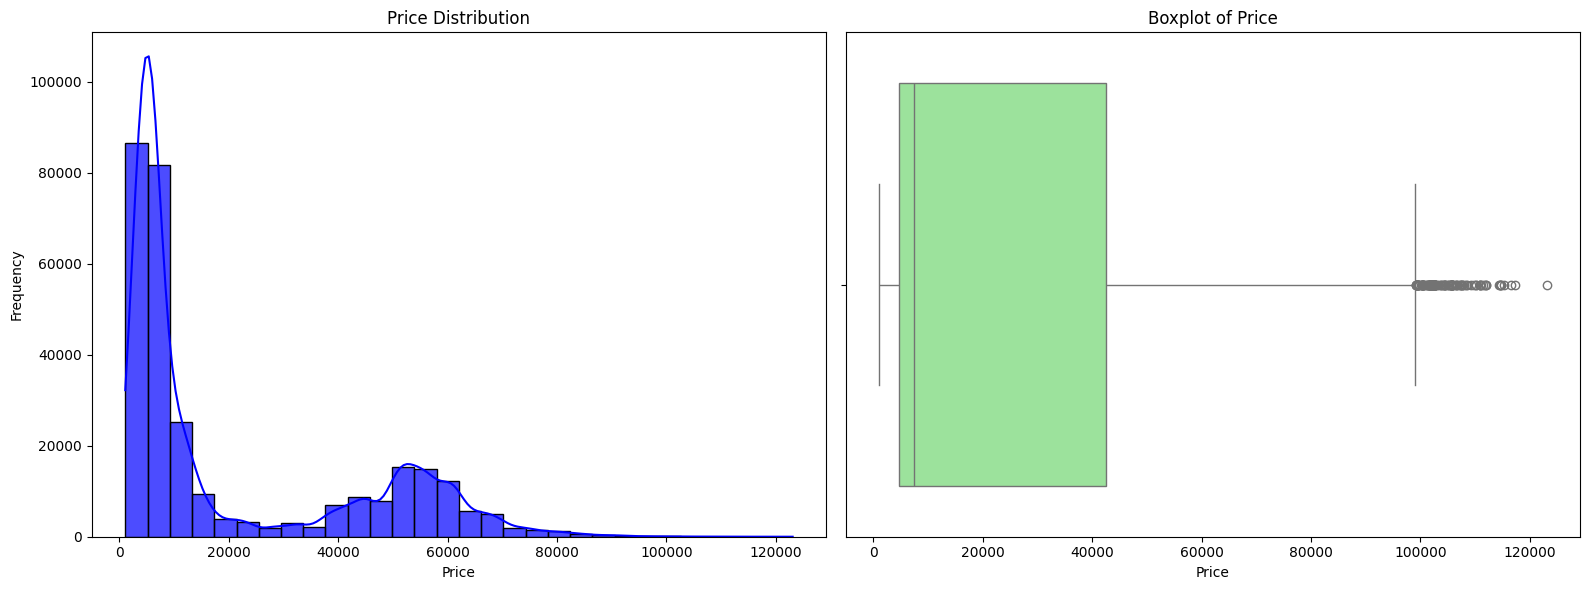

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True, bins=30, color='blue', alpha=0.7)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['price'], color='lightgreen')
plt.title('Boxplot of Price')
plt.xlabel('Price')

plt.tight_layout()
plt.show()

In [6]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")

Number of outliers: 123


In [7]:
outliers_idx = outliers.index.tolist()

In [8]:
if outliers_idx:
    df = df.drop(outliers_idx)
    print(f"Dropped {len(outliers_idx)} outlier rows.")
else:
    print("No outliers found.")
df.reset_index(drop=True, inplace=True)

Dropped 123 outlier rows.


In [9]:
df.shape

(300030, 11)

In [10]:
X=df.drop(['price'],axis=1)
y=df['price']

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((210021, 10), (90009, 10), (210021,), (90009,))

In [12]:
def adjusted_r2_score(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

In [13]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

r2_scores = {}

def evaluate_metrics(X_train, X_test, y_train_pred, y_test_pred,model_name = None):
    n_train, k_train = X_train.shape
    n_test, k_test = X_test.shape

    # MSE and RMSE
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    # R2 and Adjusted R2
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    if model_name is not None:
        r2_scores[model_name] = r2_test

    adj_r2_train = adjusted_r2_score(r2_train, n_train, k_train)
    adj_r2_test = adjusted_r2_score(r2_test, n_test, k_test)

    # MAE
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Print results
    print(f'Train MSE: {mse_train}, Test MSE: {mse_test}')
    print(f'Train RMSE: {rmse_train}, Test RMSE: {rmse_test}')
    print(f'Train R2: {r2_train}, Test R2: {r2_test}')
    print(f'Train Adjusted R2: {adj_r2_train}, Test Adjusted R2: {adj_r2_test}')
    print(f'Train MAE: {mae_train}, Test MAE: {mae_test}')

In [14]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [15]:
y_pred = rf_regressor.predict(X_test)
y_train_pred = rf_regressor.predict(X_train)

evaluate_metrics(X_train,X_test,y_train_pred,y_pred,'Random Forest')

Train MSE: 768939.4795803298, Test MSE: 5126622.062655616
Train RMSE: 876.8919429327252, Test RMSE: 2264.204509900909
Train R2: 0.9985024799175541, Test R2: 0.9899527480898075
Train Adjusted R2: 0.9985024086104696, Test Adjusted R2: 0.9899516317036755
Train MAE: 329.65284626830214, Test MAE: 865.5731702249085


Feature Selection

In [16]:
def train_and_evaluate_selected(model, X_selected, y_le):
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_le, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    n_train, k_train = X_train.shape
    n_test, k_test = X_test.shape

    # MSE and RMSE
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    # R2 and Adjusted R2
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    adj_r2_train = adjusted_r2_score(r2_train, n_train, k_train)
    adj_r2_test = adjusted_r2_score(r2_test, n_test, k_test)

    # MAE
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Print results
    print(f'Train MSE: {mse_train}, Test MSE: {mse_test}')
    print(f'Train RMSE: {rmse_train}, Test RMSE: {rmse_test}')
    print(f'Train R2: {r2_train}, Test R2: {r2_test}')
    print(f'Train Adjusted R2: {adj_r2_train}, Test Adjusted R2: {adj_r2_test}')
    print(f'Train MAE: {mae_train}, Test MAE: {mae_test}')

In [19]:
correlation_matrix = df.corr()

correlation_with_target = correlation_matrix['price'].abs().sort_values(ascending=False)

In [20]:
# top k features
for k in range(1, 11):
    selected_features = correlation_with_target[1:].head(k).index
    print(f'Top {k} features: {selected_features}')
    train_and_evaluate_selected(rf_regressor, X[selected_features], y)
    print('\n')
    

Top 1 features: Index(['class'], dtype='object')
Train MSE: 61224245.18608812, Test MSE: 60276934.558721095
Train RMSE: 7824.592333539692, Test RMSE: 7763.822161713977
Train R2: 0.8807649507750689, Test R2: 0.8818681115003154
Train Adjusted R2: 0.8807643830404867, Test Adjusted R2: 0.8818667990258579
Train MAE: 4892.370060783642, Test MAE: 4856.114852654035


Top 2 features: Index(['class', 'flight'], dtype='object')
Train MSE: 40185379.2803154, Test MSE: 40540767.65099298
Train RMSE: 6339.193898305635, Test RMSE: 6367.163234203516
Train R2: 0.9217384279373737, Test R2: 0.9205474286491264
Train Adjusted R2: 0.9217376826529499, Test Adjusted R2: 0.9205456631541294
Train MAE: 3869.0124039176717, Test MAE: 3879.85835495892


Top 3 features: Index(['class', 'flight', 'airline'], dtype='object')
Train MSE: 40185379.27616332, Test MSE: 40540617.98570939
Train RMSE: 6339.193897978143, Test RMSE: 6367.151481291253
Train R2: 0.92173842794546, Test R2: 0.92054772196601
Train Adjusted R2: 0.92173